This notebook shows how to obtain light curves via the lightkurve python package. Lightkurve objects are used in combination with TCEs as input to exovetter's vetting algorithms. For more on lightkurve (including how to create custom lightkurve objects) see https://docs.lightkurve.org/index.html

In [1]:
import lightkurve as lk
from exovetter import utils
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Searching, downloading, and flattening light curves for use in exovetter

We can use the built in `search_lightcurve()` function from lightkurve to find light curves stored from MAST and download them for use in exovetter. Here, like in the final TCE examples, we pull down TESS light curves of the known planet WASP-18 b.

In [2]:
lk_search = lk.search_lightcurve(target = 'WASP-18 b', mission = "TESS")
lk_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 02,2018,QLP,1800,100100827,0.0
3,TESS Sector 02,2018,TASOC,120,100100827,0.0
4,TESS Sector 02,2018,TASOC,1800,100100827,0.0
5,TESS Sector 02,2018,GSFC-ELEANOR-LITE,1800,100100827,0.0
...,...,...,...,...,...,...
21,TESS Sector 30,2020,SPOC,20,100100827,0.0
22,TESS Sector 30,2020,SPOC,120,100100827,0.0


From this list of results we download one of them, in this case a SPOC 2 minute light curve which was the first result returned.

In [3]:
lcf = lk_search[0].download()  
lcf

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1354.1115072617192,4.7745688e+04,2.5922741e+01,3.2845002e-03,91190,1638.57401,468.04924,4.5699730e+04,2.4585836e+01,2.1270193e+03,7.5499601e+00,4.7745688e+04,2.5922741e+01,0,———,———,———,———,1638.57401,5.5316015e-04,468.04924,5.7710981e-04,-1.2000147e-01,7.8144908e-02
1354.1128961919705,4.7782176e+04,2.5922379e+01,3.2845421e-03,91191,1638.58778,468.04160,4.5753094e+04,2.4585493e+01,2.1165220e+03,7.5075278e+00,4.7782176e+04,2.5922379e+01,0,———,———,———,———,1638.58778,5.5368309e-04,468.04160,5.7716778e-04,-1.0294508e-01,6.7404680e-02
1354.1142851224547,4.7737035e+04,2.5922800e+01,3.2845843e-03,91192,1638.58725,468.03821,4.5719250e+04,2.4585894e+01,2.1220544e+03,7.5287137e+00,4.7737035e+04,2.5922800e+01,0,———,———,———,———,1638.58725,5.5385107e-04,468.03821,5.7766296e-04,-1.0323820e-01,6.3302755e-02
1354.117062983188,4.7739652e+04,2.5921152e+01,3.2846683e-03,91194,1638.58337,468.02563,4.5696863e+04,2.4584332e+01,2.1406106e+03,7.5460734e+00,4.7739652e+04,2.5921152e+01,0,———,———,———,———,1638.58337,5.5345549e-04,468.02563,5.7999988e-04,-1.0774896e-01,5.0843615e-02
1354.1184519134392,4.7759828e+04,2.5928436e+01,3.2847102e-03,91195,1638.59648,468.05560,4.5737141e+04,2.4591240e+01,2.1321707e+03,7.5400863e+00,4.7759828e+04,2.5928436e+01,0,———,———,———,———,1638.59648,5.5386929e-04,468.05560,5.7663023e-04,-9.3161479e-02,8.3432972e-02
1354.1198408439234,4.7727695e+04,2.5917774e+01,3.2847524e-03,91196,1638.59691,468.04240,4.5714668e+04,2.4581129e+01,2.1199805e+03,7.5265331e+00,4.7727695e+04,2.5917774e+01,0,———,———,———,———,1638.59691,5.5403763e-04,468.04240,5.7726464e-04,-9.2094876e-02,6.8144821e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381.510514525368,4.7724891e+04,2.6401802e+01,3.6914796e-03,110917,1638.68105,467.98689,4.5899270e+04,2.5040192e+01,2.8671475e+03,8.3084249e+00,4.7724891e+04,2.6401802e+01,0,———,———,———,———,1638.68105,5.6833116e-04,467.98689,5.8781775e-04,1.2774169e-02,5.1160059e-03


We can then clean up this light curve for use in exovetter by removing rows with nans in the pdcsap_flux column, removing outliers, and flattening.

# Q: should mask be in btjd? Currently epoch value applied to mask is mjd, lightkurve docs aren't specific.

In [4]:
# Remove NaNs and poor quality cadences
lcf = lcf[~np.isnan(lcf["pdcsap_flux"])]
lcf = lcf.remove_outliers(sigma_lower=8, sigma_upper=4) 

# In order to mask out the transits when flattening, use info from a TCE
tce_list = utils.get_mast_tce("WASP-18 b")
tce = tce_list[0]

# Flatten the light curve (mask out actual transit then apply filter)
transit_mask = lcf.create_transit_mask(transit_time=tce['epoch'], period=tce['period'], duration=tce['duration'])
lc_flat = lcf.flatten(mask=transit_mask)
lc_flat


time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1354.1115072617192,9.9998477e-01,5.4292539e-04,3.2845002e-03,91190,1638.57401,468.04924,4.5699730e+04,2.4585836e+01,2.1270193e+03,7.5499601e+00,4.7745688e+04,2.5922741e+01,0,———,———,———,———,1638.57401,5.5316015e-04,468.04924,5.7710981e-04,-1.2000147e-01,7.8144908e-02
1354.1128961919705,1.0007303e+00,5.4290768e-04,3.2845421e-03,91191,1638.58778,468.04160,4.5753094e+04,2.4585493e+01,2.1165220e+03,7.5075278e+00,4.7782176e+04,2.5922379e+01,0,———,———,———,———,1638.58778,5.5368309e-04,468.04160,5.7716778e-04,-1.0294508e-01,6.7404680e-02
1354.1142851224547,9.9976659e-01,5.4290656e-04,3.2845843e-03,91192,1638.58725,468.03821,4.5719250e+04,2.4585894e+01,2.1220544e+03,7.5287137e+00,4.7737035e+04,2.5922800e+01,0,———,———,———,———,1638.58725,5.5385107e-04,468.03821,5.7766296e-04,-1.0323820e-01,6.3302755e-02
1354.117062983188,9.9980340e-01,5.4286227e-04,3.2846683e-03,91194,1638.58337,468.02563,4.5696863e+04,2.4584332e+01,2.1406106e+03,7.5460734e+00,4.7739652e+04,2.5921152e+01,0,———,———,———,———,1638.58337,5.5345549e-04,468.02563,5.7999988e-04,-1.0774896e-01,5.0843615e-02
1354.1184519134392,1.0002083e+00,5.4300522e-04,3.2847102e-03,91195,1638.59648,468.05560,4.5737141e+04,2.4591240e+01,2.1321707e+03,7.5400863e+00,4.7759828e+04,2.5928436e+01,0,———,———,———,———,1638.59648,5.5386929e-04,468.05560,5.7663023e-04,-9.3161479e-02,8.3432972e-02
1354.1198408439234,9.9951797e-01,5.4277251e-04,3.2847524e-03,91196,1638.59691,468.04240,4.5714668e+04,2.4581129e+01,2.1199805e+03,7.5265331e+00,4.7727695e+04,2.5917774e+01,0,———,———,———,———,1638.59691,5.5403763e-04,468.04240,5.7726464e-04,-9.2094876e-02,6.8144821e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381.510514525368,9.9995196e-01,5.5318165e-04,3.6914796e-03,110917,1638.68105,467.98689,4.5899270e+04,2.5040192e+01,2.8671475e+03,8.3084249e+00,4.7724891e+04,2.6401802e+01,0,———,———,———,———,1638.68105,5.6833116e-04,467.98689,5.8781775e-04,1.2774169e-02,5.1160059e-03


We can visualize the flattened light curve which can be used as an input to exovetter's vetters with the built in lightkurve `plot` method.

<Figure size 640x480 with 0 Axes>

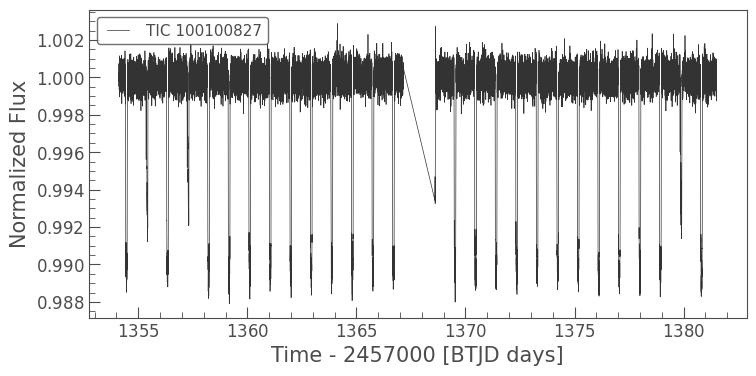

In [5]:
plt.figure()
lc_flat.plot()
plt.show()

We can also save the modified light curve to a fits file to be used later or shared.

In [6]:
# replace flux with pdcsap_flux since the to_fits method populates the fits file from these two columns
lc_flat['flux'] = lc_flat['pdcsap_flux']
lc_flat['flux_err'] = lc_flat['pdcsap_flux_err']

lc_flat.to_fits(path='WASP18b_lightcurve.fits', overwrite=True)

In [7]:
with fits.open('WASP18b_lightcurve.fits') as hdul:
    hdul.info()
    h = hdul[1].header
    

Filename: WASP18b_lightcurve.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  LIGHTCURVE    1 BinTableHDU     28   18299R x 7C   [D, E, E, J, D, D, J]   


In [8]:
lc_flat = lk.read('WASP18b_lightcurve.fits')
lc_flat

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,electron / s,electron / s,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
1354.1115072617192,47745.6875,25.922740936279297,91190,1638.5740089908536,1638.5740089908536,468.0492448962196,468.0492448962196,0
1354.1128961919705,47782.17578125,25.922378540039062,91191,1638.5877809265594,1638.5877809265594,468.04160067741094,468.04160067741094,0
1354.1142851224547,47737.03515625,25.922800064086914,91192,1638.587247854686,1638.587247854686,468.03820601846934,468.03820601846934,0
1354.117062983188,47739.65234375,25.921152114868164,91194,1638.5833677302496,1638.5833677302496,468.0256331755071,468.0256331755071,0
1354.1184519134392,47759.828125,25.928436279296875,91195,1638.5964847883904,1638.5964847883904,468.05559705741166,468.05559705741166,0
1354.1198408439234,47727.6953125,25.917774200439453,91196,1638.5969068583083,1638.5969068583083,468.0423965420949,468.0423965420949,0
...,...,...,...,...,...,...,...,...
1381.510514525368,47724.890625,26.40180206298828,110917,1638.681050918677,1638.681050918677,467.98689352673523,467.98689352673523,0
